In [1]:
import scipy.spatial.distance as d
import numpy as np
from scipy.sparse import csr_matrix

# benchmark performance 
x = np.random.random((1000, 10000))
# binarize
x[x > 0.3] = 0
x[x>0] = 1
mat =  csr_matrix(x)

In [2]:
import collections

In [3]:
from scipy.sparse import csr_matrix


def pairwise_jaccard(X):
    """Computes the Jaccard index between the rows of `X`.
    """
    X = X.astype(bool).astype(int)

    intrsct = X.dot(X.T)
    row_sums = intrsct.diagonal()
    unions = row_sums[:,None] + row_sums - intrsct
    index = intrsct / unions
    return index

In [4]:
import pickle
with open('x.pydata', 'rb') as f:
    x = pickle.load(f)

In [5]:
%time mat =  csr_matrix(x)

In [6]:
x.shape

(1350, 494455)

In [7]:
%time x_jac = pairwise_jaccard(mat)

CPU times: user 4.99 s, sys: 113 ms, total: 5.11 s
Wall time: 5.11 s


In [8]:
x_jac[x_jac == 1] = x_jac.mean()

In [9]:
x_jac[x_jac == 1] = None

In [10]:
exp_list = np.zeros((len(x),len(x)))

In [11]:
bin_num = len(x[0])

bin_counts = []
for i in range(len(x)):
    bin_counts.append(len(x[i][x[i]==1]))

n = 0
for i in range(len(x)):
    for j in range(len(x)):
        exp_list[i][j] = 1/(bin_num/bin_counts[i]+bin_num/bin_counts[j]-1)
        

In [106]:
import time

tt = time.time()
bin_num = len(x[0])

bin_counts = []
for i in range(len(x)):
    bin_counts.append(len(x[i][x[i]==1]))

n = 0
for i in range(len(x)):
    for j in range(len(x)):
        exp_list[i][j] = 1/(bin_num/bin_counts[i]+bin_num/bin_counts[j]-1)
print(time.time()-tt)

8.167036771774292


In [117]:
from numba import jit


@jit(nopython = True, parallel = True)
def expected_jaccard(x):
    bin_num = len(x[0])

    bin_counts = []
    for i in range(len(x)):
        bin_counts.append(len(x[i][x[i]==1]))
    
    exp_list = np.zeros((len(x),len(x)))
    n = 0
    for i in range(len(x)):
        for j in range(len(x)):
            exp_list[i][j] = 1/(bin_num/bin_counts[i]+bin_num/bin_counts[j]-1)
    return exp_list

In [120]:
%time exp_list = expected_jaccard(x)

CPU times: user 4.75 s, sys: 1.44 s, total: 6.19 s
Wall time: 1.51 s


In [119]:
exp = np.ravel(exp_list)

In [13]:
jac = np.ravel(x_jac)

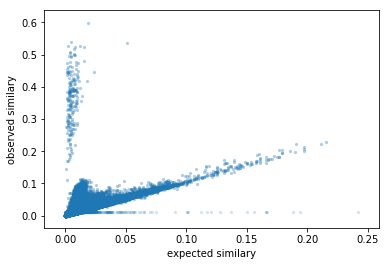

In [121]:
import matplotlib.pyplot as plt 
plt.scatter(exp, jac, s=10, alpha=0.2, linewidths=0)
plt.xlabel('expected similary')
plt.ylabel('observed similary')
plt.show()

In [15]:
import statsmodels.api as sm

model = sm.OLS(jac, exp)
results = model.fit()

In [16]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                          6.453e+06
Date:                Mon, 19 Aug 2019   Prob (F-statistic):                        0.00
Time:                        13:07:27   Log-Likelihood:                      6.4162e+06
No. Observations:             1822500   AIC:                                 -1.283e+07
Df Residuals:                 1822499   BIC:                                 -1.283e+07
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

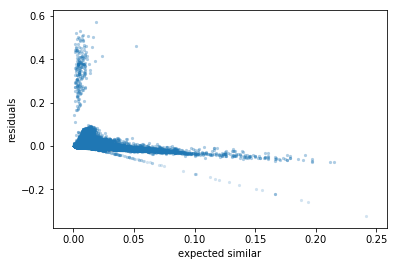

In [17]:
plt.scatter(exp, results.resid, s=10, alpha=0.2, linewidths=0)
plt.xlabel('expected similar')
plt.ylabel('residuals')
plt.show()

In [344]:
results.resid.shape

(1822500,)

In [18]:
x_norm = results.resid.reshape(1350, 1350)

In [19]:
from sklearn.preprocessing import scale

x_norm = scale(x_norm)

height_threshold = 5
low_threshold = -5

x_norm[x_norm > height_threshold] = height_threshold
x_norm[x_norm < low_threshold] = low_threshold

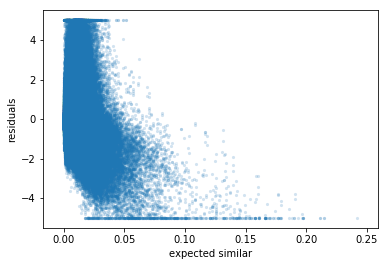

In [123]:
plt.scatter(exp, x_norm, s=10, alpha=0.2, linewidths=0)
plt.xlabel('expected similar')
plt.ylabel('residuals')
plt.show()

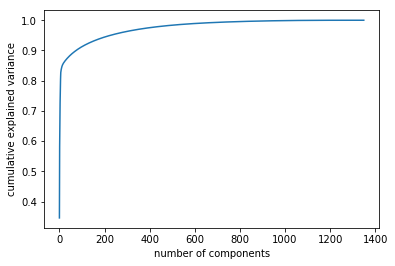

In [95]:
from sklearn.decomposition import PCA

pca = PCA().fit(x_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [35]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
len(cumsum[cumsum < .85])

7

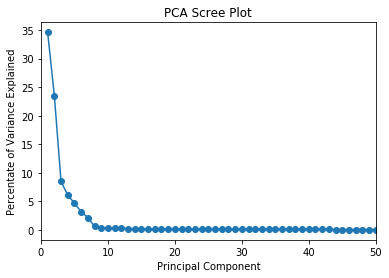

In [96]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)

plt.plot(range(1, len(percent_variance)+1), percent_variance, '-o')
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.xlim(0, 50)
plt.show()

In [97]:
pca = PCA(n_components=7, random_state=42)
pca.fit(x_norm)
X_pca = pca.transform(x_norm)

In [98]:
from sklearn.neighbors import NearestNeighbors

k = 15
snn_prune = 0.05/15

nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

In [99]:
import networkx as nx
import community

G = nx.Graph()

for indice in indices:
    for i in range(len(indice)):
        for j in range(i+1, len(indice)):
            weight = x_jac[indice[i], indice[j]]
            G.add_edge(indice[i], indice[j], weight = weight)

In [100]:
partition = community.best_partition(G, resolution=1)
part = collections.defaultdict(list)
for k,v in partition.items():
    part[v].append(int(k))

In [101]:
import umap

embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(X_pca)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


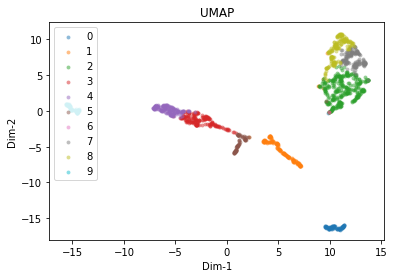

In [102]:
for key in part.keys():
    plt.scatter(embedding[part[key], 0], embedding[part[key], 1], s=15, alpha=0.5, linewidths=0, label=key)

plt.title('UMAP')
plt.xlabel('Dim-1')
plt.ylabel('Dim-2')
plt.legend()
plt.show()